In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
%matplotlib widget

f = pickle.load(open('G089.75_5.sav','rb')) 

Text(0.5, 0, '$V_{lsr}$')

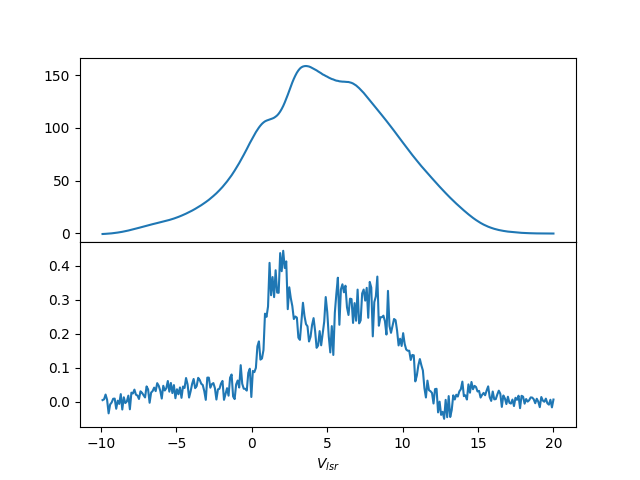

In [2]:
def gaussian(x,h,mu,sig):
    return h*np.exp(-np.power(x-mu,2.)/(2*np.power(sig,2.)))
#Read stokes
vel = f['vel1']
stk_i = f['stk_iall']
stk_q = f['stk_qall']
stk_u = f['stk_uall']
stk_v = f['stk_vall']
fig1,ax1 = plt.subplots(2,sharex=True,gridspec_kw={'hspace':0})
ax1[0].plot(vel,stk_i)
ax1[1].plot(vel,stk_v)
ax1[1].set_xlabel(r'$V_{lsr}$')

In [3]:
from lmfit import Minimizer,Parameters
#define class for stokes I
class stokes_I:
    def __init__(self,x,stk_i):
        self.params = Parameters()
        self.cnmCount = 0
        self.wnmCount = 0
        self.hinsaCount = 0
        self.x = x
        self.stk_i = stk_i
    
    def addCNM(self,props,vary=[True,True,True,True],
               lbound=[None,None,None,None],
               ubound=[None,None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that CNM to the model
        '''
        self.cnmCount += 1
        self.params.add_many((f'h{self.cnmCount}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f't{self.cnmCount}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'c{self.cnmCount}',props[2],vary[2],lbound[2],ubound[2],None,None),
                             (f'w{self.cnmCount}',props[3],vary[3],lbound[3],ubound[3],None,None))
        

    def addWNM(self,props,vary=[True,True,True],
               lbound=[None,None,None],
               ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that WNM to the model
        '''
        self.wnmCount += 1
        self.params.add_many((f'hw{self.wnmCount}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f'cw{self.wnmCount}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'ww{self.wnmCount}',props[2],vary[2],lbound[2],ubound[2],None,None))
        

    def addHINSA(self,props,vary=[True,True,True],
                 lbound=[None,None,None],
                 ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds HINSA to the model
        '''
        self.params.add_many(('t0',props[0],vary[0],lbound[0],ubound[0],None,None),
                             ('c0',props[1],vary[1],lbound[1],ubound[1],None,None),
                             ('w0',props[2],vary[2],lbound[2],ubound[2],None,None))
        self.hinsaCount += 1

    def performFit(self,order=None):
        if order==None:
            order=[i+1 for i in range(self.cnmCount)]
        self.order = order
        fitter = Minimizer(self.fitfunc,self.params)
        self.result = fitter.minimize(method='leastsq')

    def fitfunc(self,params):
        model = self.stokesI(params)
        return abs(self.stk_i-model)

    def stokesI(self,params,ax=None):
        order = self.order
        x = self.x
        tau = np.zeros(shape=(self.cnmCount+1,len(x)))
        Tc = np.empty(shape=(self.cnmCount,len(x)))
        Tw = np.empty(shape=(self.wnmCount,len(x)))

        #Calculate tau for each component
        tau[0] = gaussian(x,params['t0'],params['c0'],params['w0'])
        #Calculate Tc based on the oredering
        for n,i in enumerate(order):
            tau_cur = gaussian(x,params[f't{i}'],params[f'c{i}'],params[f'w{i}'])
            tau[i] = tau_cur
            Tc_cur = params[f'h{i}']*(1-np.exp(-tau_cur))*np.exp(-np.sum(tau[order[:n]],axis=0))*np.exp(-tau[0])
            Tc[i-1] = Tc_cur

        tau_tot = np.sum(tau,axis=0)
        
        #Calcuate all wnm profiles
        for i in range(self.wnmCount):
            Tw_cur = np.exp(-tau_tot)*gaussian(vel,params[f'hw{i+1}'],params[f'cw{i+1}'],params[f'ww{i+1}'])
            Tw[i] = Tw_cur

        Tc_tot = np.sum(Tc,axis=0)
        Tw_tot = np.sum(Tw,axis=0)

        ret = Tc_tot + Tw_tot
        
        if ax != None:
            ax.plot(x,ret,label='fit')
            for i in range(self.wnmCount):
                ax.plot(x,Tw[i]/np.exp(-tau[0]),label=f'WNM{i+1}')
            for i in range(self.cnmCount):
                ax.plot(x,Tc[i]/np.exp(-tau[0]),label=f'CNM{i+1}')
            HINSA = (np.sum(Tc,axis=0)+np.sum(Tw,axis=0))*(1-np.exp(-tau[0]))/(np.exp(-tau[0]))
            ax.plot(x,HINSA,label='HINSA')
            ax.plot(x,self.stk_i,label='Stokes I')
        
        return ret

    def plot(self):
        fig2,ax = plt.subplots(1)
        self.stokesI(self.result.params,ax=ax)
        ax.legend()
        





In [4]:
#define class for stokes V
class stokes_V:
    def __init__(self,stokesIModel,stk_v):
        self.Iparams = stokesIModel.result.params
        self.wnmCount = stokesIModel.wnmCount
        self.cnmCount = stokesIModel.cnmCount
        self.totComp = self.wnmCount + self.cnmCount + 1
        self.stk_i = stokesIModel.stk_i
        self.x = stokesIModel.x
        self.stk_v = stk_v
        self.order = stokesIModel.order
    
    def addParams(self,vals,vary=None,
                  lbound=None,
                  ubound=None):
        
        if len(vals) < self.totComp + 1:
            print(self.cnmCount)
            print(self.wnmCount)
            raise RuntimeError(f"""Please pass values for all components. 
                               You passed {len(vals)} values, while {self.totComp+1} were expected. 
                               Remember to pass a value for leakage too!""")
        
        if vary == None:
            vary = [True]*(self.totComp+1)
        if lbound == None:
            vary = [None]*(self.totComp+1)
        if ubound == None:
            vary = [None]*(self.totComp+1)
        
        self.params = Parameters()
        print(vals,vals[0])
        self.params.add(f'b0',vals[0],vary[0],lbound[0],ubound[0],None,None)
        for i in range(self.cnmCount):
            self.params.add(f'b{i+1}',vals[i+1],vary[i+1],lbound[i+1],ubound[i+1],None,None)
        for i in range(self.wnmCount):
            j = self.cnmCount + i + 1
            self.params.add(f'bw{i+1}',vals[j],vary[j],lbound[j],ubound[j],None,None)
        
        self.params.add('c',vals[j+1],vary[j+1],lbound[j+1],ubound[j+1])
        
        
    def performFit(self):
        fitter = Minimizer(self.fitfunc,self.params)
        self.result = fitter.minimize(method='leastsq')

    def fitfunc(self,params):
        data = self.stk_v
        model = self.stokesV(params)
        return abs(data-model)
        
    def stokesV(self,params,ax=[]):
        Iparams = self.Iparams
        x = self.x
        stk_i = self.stk_i
        stk_v = self.stk_v
        order = self.order
        if order==None:
            order=[i+1 for i in range(self.cnmCount)]

        tau = np.zeros(shape=(self.cnmCount+1,2,len(x)))
        Tc = np.empty(shape=(self.cnmCount,2,len(x)))
        Tw = np.empty(shape=(self.wnmCount,2,len(x)))

        #Calculate tau for each component
        tau[0,0] = gaussian(x,Iparams['t0'],Iparams['c0']+params['b0'],Iparams['w0']) #RCP
        tau[0,1] = gaussian(x,Iparams['t0'],Iparams['c0']-params['b0'],Iparams['w0']) #LCP
        #Calculate Tc based on the oredering
        for n,i in enumerate(order):
            tau_cur_RCP = gaussian(x,Iparams[f't{i}'],Iparams[f'c{i}']+params[f'b{i}'],Iparams[f'w{i}'])
            tau_cur_LCP = gaussian(x,Iparams[f't{i}'],Iparams[f'c{i}']-params[f'b{i}'],Iparams[f'w{i}'])
            tau[i,0] = tau_cur_RCP
            tau[i,1] = tau_cur_LCP

            Tc_cur_RCP = 0.5*Iparams[f'h{i}']*(1-np.exp(-tau_cur_RCP))*np.exp(-np.sum(tau[order[:n],0],axis=0))*np.exp(-tau[0,0])
            Tc_cur_LCP = 0.5*Iparams[f'h{i}']*(1-np.exp(-tau_cur_LCP))*np.exp(-np.sum(tau[order[:n],1],axis=0))*np.exp(-tau[0,1])
            Tc[i-1,0] = Tc_cur_RCP
            Tc[i-1,1] = Tc_cur_LCP

        tau_tot_RCP = np.sum(tau,axis=0)[0]
        tau_tot_LCP = np.sum(tau,axis=0)[1]
        
        #Calcuate all wnm profiles
        for i in range(self.wnmCount):
            Tw_cur_RCP = 0.5*np.exp(-tau_tot_RCP)*gaussian(vel,Iparams[f'hw{i+1}'],Iparams[f'cw{i+1}']+params[f'bw{i+1}'],Iparams[f'ww{i+1}'])
            Tw_cur_LCP = 0.5*np.exp(-tau_tot_LCP)*gaussian(vel,Iparams[f'hw{i+1}'],Iparams[f'cw{i+1}']-params[f'bw{i+1}'],Iparams[f'ww{i+1}'])
            Tw[i,0] = Tw_cur_RCP
            Tw[i,1] = Tw_cur_LCP

        Tc_tot_RCP = np.sum(Tc,axis=0)[0]
        Tc_tot_LCP = np.sum(Tc,axis=0)[1]
        Tw_tot_RCP = np.sum(Tw,axis=0)[0]
        Tw_tot_LCP = np.sum(Tw,axis=0)[1]
        
        tot_v = (Tc_tot_RCP + Tw_tot_RCP) - (Tc_tot_LCP + Tw_tot_LCP)
        ret = tot_v + params['c']*stk_i
        if len(ax)!=0:
            ax[0].step(x,stk_v-params['c']*stk_i)
            ax[0].plot(x,tot_v,'r-',label='fit')
            for i in range(self.wnmCount):
                ax[0].plot(x,Tw[i,0] - Tw[i,1],label=f'WNM{i+1}',linestyle='--')
            for i in range(self.cnmCount):
                ax[0].plot(x,Tc[i,0] - Tc[i,1],label=f'CNM{i+1}',linestyle='--')
            ax[1].step(x,stk_v-ret)
            ax[1].axhline(0,color='k')

        self.tau = tau
        self.Tc = Tc
        self.Tw = Tw
        return ret
    
    def plot(self,components=False):
        if not components:
            fig,ax = plt.subplots(2,sharex=True,gridspec_kw={'hspace':0},figsize=(8,4))
            self.stokesV(self.result.params,ax = ax)
            box = ax[0].get_position()
            ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            box = ax[1].get_position()
            ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
            
        else:
            fig,ax = plt.subplots(self.totComp,sharex=True,gridspec_kw={'hspace':0},figsize=(6,self.totComp*2))
            self.components(ax)

    def components(self,ax):
        x = self.x
        stk_v = self.stk_v
        stk_i = self.stk_i
        Vparams = self.result.params

        dvdf = 2.9979e5/1420.40575e6
        zf = 2.8

        Tc_noHINSA = np.empty(shape=(self.cnmCount,len(x)))
        Tw_noHINSA = np.empty(shape=(self.wnmCount,len(x)))
        B = np.empty(shape=(self.cnmCount+self.wnmCount+1))
        Berr = np.empty(shape=(self.cnmCount+self.wnmCount+1))
        ax[0].set_xlim(-10,20)
        
        Tc = self.Tc
        Tw = self.Tw
        tau = self.tau

        B[0] = round(Vparams['b0']/dvdf*2/zf,1)
        Berr[0] = round(Vparams['b0'].stderr/dvdf*2/zf,1)

        for i in range(self.cnmCount):
            Tc_noHINSA[i] = Tc[i,0]/np.exp(-tau[0,0]) - Tc[i,1]/np.exp(-tau[0,1])
            B[i+1] = round(Vparams[f'b{i+1}']/dvdf*2/zf,1)
            Berr[i+1] = round(Vparams[f'b{i+1}'].stderr/dvdf*2/zf,1)

        for i in range(self.wnmCount):
            Tw_noHINSA[i] = Tw[i,0]/np.exp(-tau[0,0]) - Tw[i,1]/np.exp(-tau[0,1])
            B[self.cnmCount+i+1] = round(Vparams[f'bw{i+1}']/dvdf*2/zf,1)
            Berr[self.cnmCount+i+1] = round(Vparams[f'bw{i+1}'].stderr/dvdf*2/zf,1)

        RCP = (np.sum(Tc[:,0],axis=0) + np.sum(Tw[:,0],axis=0))
        LCP = (np.sum(Tc[:,1],axis=0) + np.sum(Tw[:,1],axis=0))
        HINSA = (RCP - LCP) - np.sum(Tc_noHINSA,axis=0) - np.sum(Tw_noHINSA,axis=0)
        res = stk_v - (RCP-LCP) - Vparams['c']*stk_i

        self.plotComponent(ax[0],res,HINSA,text=rf'HINSA=${B[0]}\pm{Berr[0]}$')
        for i in range(self.cnmCount):
            self.plotComponent(ax[i+1],res,Tc_noHINSA[i],text=rf'CNM{i+1}=${B[i+1]}\pm{Berr[i+1]}$')
        for i in range(self.wnmCount):
            self.plotComponent(ax[i+self.cnmCount+1],res,Tw_noHINSA[i],text=rf'WNM{i+1}=${B[i+self.cnmCount+1]}\pm{Berr[i+self.cnmCount+1]}$')

    def plotComponent(self,ax,res,y,text=None,color='r',label=None):
        ax.step(self.x,res+y,color='k',linewidth=0.5)
        ax.text(-10,0.1,text)
        ax.plot(self.x,y,color=color,label=label)
        


In [5]:
#Define number of cnm and wnm components and their starting parameters


stokesIModel = stokes_I(vel,stk_i)

stokesIModel.addCNM([100,0.1,1,1.5],
             [True,True,True,True],
             [0,0,0,0.5],
             [200,2,3,2])

stokesIModel.addCNM([120,0.3,2.67,2],
             [True,True,True,True],
             [0,0,1.8,0.5],
             [200,2,3.5,3])

stokesIModel.addWNM([80,10.62,4],
             [True,True,True,True],
             [0,8,0],
             [150,12,5])

stokesIModel.addHINSA([0.3,1.89,00.7],
                      [True,True,True],
                      [0,1.7,0.4],
                      [10,2.0,2])
#Define order
order=[2,1]
#2134
stokesIModel.performFit(order = order)
print(stokesIModel.result.message)
display(stokesIModel.result.params)

Fit succeeded. Could not estimate error-bars.


name,value,initial value,min,max,vary
h1,199.999557,100,0.00000000,200.000000,True
t1,0.68040768,0.1,0.00000000,2.00000000,True
c1,2.99999991,1,0.00000000,3.00000000,True
w1,0.72481767,1.5,0.50000000,2.00000000,True
h2,199.999998,120,0.00000000,200.000000,True
t2,1.15095024,0.3,0.00000000,2.00000000,True
c2,3.31265805,2.67,1.80000000,3.50000000,True
w2,3.00000000,2,0.50000000,3.00000000,True
hw1,91.5713118,80,0.00000000,150.000000,True
cw1,8.00000000,10.62,8.00000000,12.0000000,True


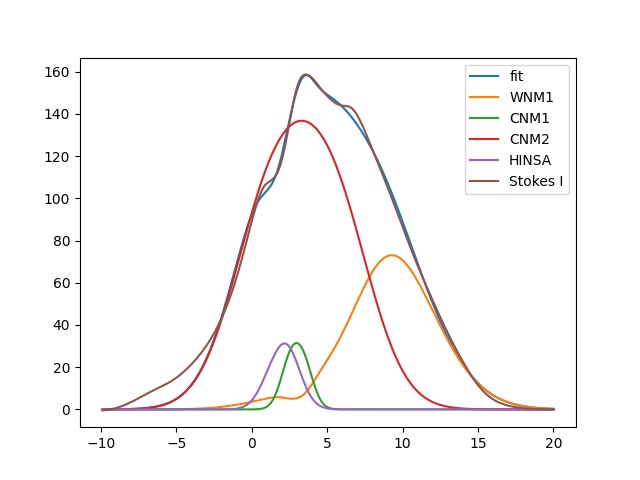

In [6]:
stokesIModel.plot()

In [7]:
stkVModel = stokes_V(stokesIModel,stk_v)
stkVModel.addParams([0.02,-0.01,0.01,0.002,0.01,0.05,0.00034],
                    [True,True,True,True,True,True,True],
                    [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,0],
                    [0.1,0.1,0.1,0.1,0.1,0.1,1e-2])

stkVModel.performFit()
print(stkVModel.result.message)
display(stkVModel.result.params)

[0.02, -0.01, 0.01, 0.002, 0.01, 0.05, 0.00034] 0.02
Fit succeeded.


name,value,standard error,relative error,initial value,min,max,vary
b0,0.00114494,5.5502e-04,(48.48%),0.02,-0.10000000,0.10000000,True
b1,-0.00781016,5.3461e-04,(6.85%),-0.01,-0.10000000,0.10000000,True
b2,0.00224308,2.5371e-04,(11.31%),0.01,-0.10000000,0.10000000,True
bw1,-0.00252130,4.0913e-04,(16.23%),0.002,-0.10000000,0.10000000,True
c,0.00186678,3.1466e-05,(1.69%),0.01,-0.10000000,0.10000000,True


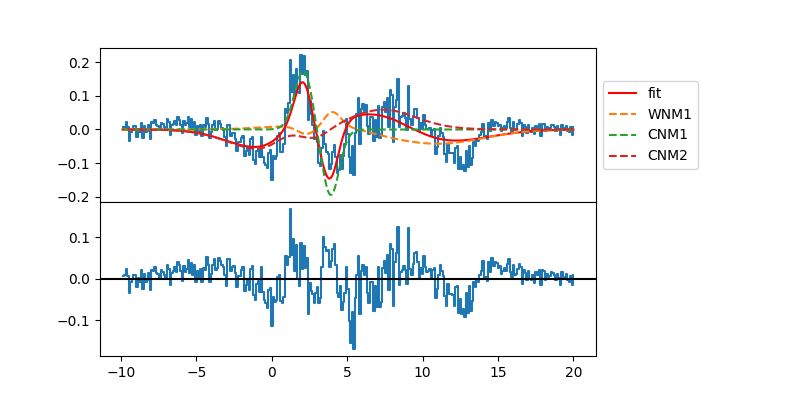

In [8]:
stkVModel.plot()

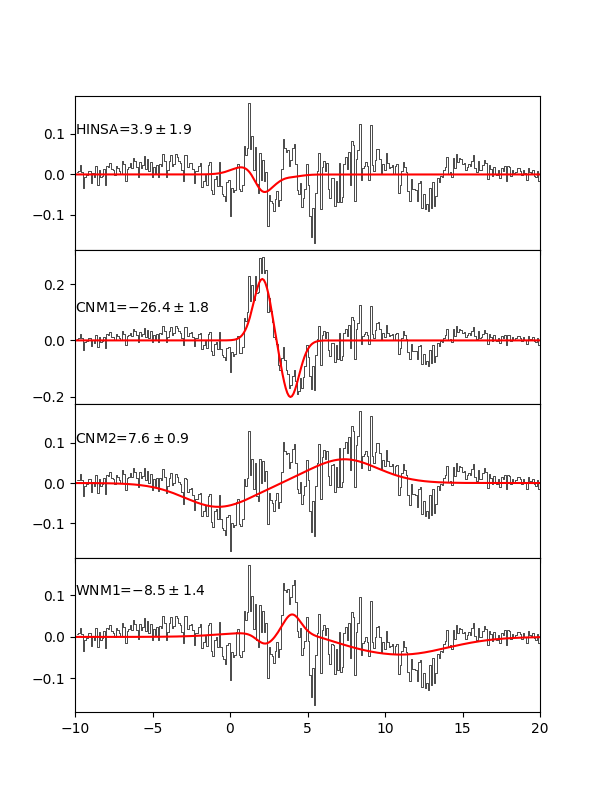

In [9]:
stkVModel.plot(True)